In [336]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import movie_reviews
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
import re
from sklearn.model_selection import KFold
from collections import Counter
import pickle
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from gensim.utils import lemmatize
import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [337]:
def preprocess_reviews(reviews):
    REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [340]:
#download data

train_df = pd.read_csv('products_sentiment_train.tsv',delimiter='\t',encoding='utf-8',header=None)
train_df.columns = ['text','target']
test_df = pd.read_csv('products_sentiment_test.tsv',delimiter='\t',encoding='utf-8')
test_df.head()

train_reviews = train_df['text'].values
labels = train_df['target']
test_reviews = test_df['text']

#open appos dict
pickle_in = open('appos.pickle','rb')
appos = pickle.load(pickle_in)
pickle_in.close()

stop_words = stopwords.words('english')

#Cleaning text via regEx func
train_df['text'] = preprocess_reviews(train_df['text'].values)
test_df['text'] = preprocess_reviews(test_df['text'].values)

all_reviews = pd.concat([train_df,test_df])

In [339]:
def cleaning_function(tips):
    all_ = []
    for tip in tqdm(tips):
        time.sleep(0.0001)
        
#       Decoding function
        decode = tip.decode("utf-8-sig")
    
#       Lowercasing before negation
        lower_case = decode.lower()
    
#       Replace apostrophes with words
        words = lower_case.split()
        split = [appos[word] if word in appos else word for word in words]
        reformed = " ".join(split) 
        
#       Lemmatization
        lemm = lemmatize(lower_case)
        all_.append(lemm)
        
    return all_
def separate_word_tag(df_lem_test):
    words=[]
    types=[]
    df= pd.DataFrame()
    for row in df_lem_test:
        sent = []
        type_ =[]
        for word in row:
            split = word.split('/')
            sent.append(split[0])
            type_.append(split[1])
        words.append(' '.join(word for word in sent))
        types.append(' '.join(word for word in type_))
    df['lem_words']= words
    df['lem_tag']= types
    return df

#Cleaning the input data

word_tag = cleaning_function(all_reviews.text)
lemm_df = separate_word_tag(word_tag)
# concat cleaned text with original

df_training = pd.concat([all_reviews['text'].reset_index(drop=True), lemm_df], axis=1)
df_training['word_tags'] = word_tag
df_training.loc[1606] = 'is worth it'
df_training.head()

# New versions of train and test DF's

train_df = df_training.iloc[:2000]
train_df['target'] = labels
test_df = pd.concat([test_df['Id'], df_training.iloc[2000:].reset_index(drop=True)],axis=1)

train_df.to_csv('train_cleaned.csv',index=False)
test_df.to_csv('test_cleaned.csv',index=False)

In [352]:
#Bootstrap subsampling

train,test = train_test_split(train_df,test_size = 0.3,random_state = 42,shuffle=True)

t_negative = train[train.target == 0].sample(900,replace = True)
t_positive = train[train.target == 1].sample(900,replace = True)

train_bs = pd.concat([t_negative,t_positive])

train_bs.reset_index(drop=True,inplace=True)
train_bs.to_csv('bootstrap_train.csv',index=False)

test.reset_index(drop=True,inplace=True)
test.to_csv('cross_cal_test.csv',index=False)

In [353]:
df_training.head()

,text,lem_words,lem_tag,word_tags
0,2 take around 10000 640x480 pictures,take picture,VB NN,"[take/VB, picture/NN]"
1,i downloaded a trial version of computer assoc...,download trial version computer associate ez f...,VB NN NN NN NN VB JJ NN VB NN NN NN NN RB,"[download/VB, trial/NN, version/NN, computer/N..."
2,the wrt54g plus the hga7t is a perfect solutio...,wrt hga be perfect solution need wireless cove...,JJ JJ VB JJ NN VB JJ NN JJ NN JJ JJ NN VB NN,"[wrt/JJ, hga/JJ, be/VB, perfect/JJ, solution/N..."
3,i dont especially like how music files are uns...,dont especially like music file be unstructure...,VB RB VB NN NN VB JJ RB VB RB VB NN NN VB NN N...,"[dont/VB, especially/RB, like/VB, music/NN, fi..."
4,i was using the cheapie pail and it worked ok...,be used cheapie pail work opening device fall ...,VB VB JJ NN VB JJ NN VB RB,"[be/VB, used/VB, cheapie/JJ, pail/NN, work/VB,..."


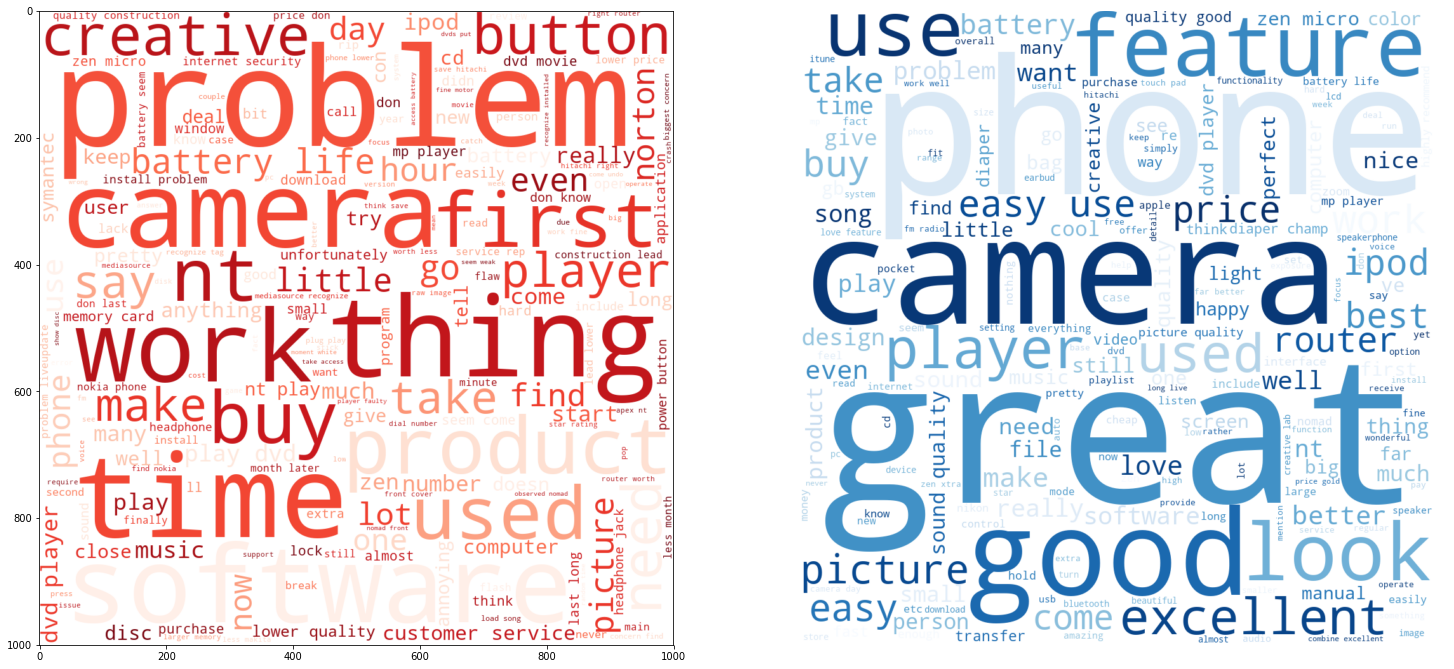

In [357]:
# Polarity == 0 negative
fig, ax = plt.subplots(1,2,figsize=(25,20))
train_s0 = train_bs[train_bs.target ==0]
all_text = ' '.join(word for word in train_s0.lem_words)
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
# plt.figure(figsize=(20,10))
ax[0].imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
# plt.show()
# Polarity == 1 neutral
train_s1 = train_bs[train_bs.target ==1]
all_text = ' '.join(word for word in train_s1.lem_words)
wordcloud = WordCloud(width=1000, height=1000, colormap='Blues', background_color='white', mode='RGBA').generate(all_text)
# plt.figure( figsize=(20,10))
ax[1].imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
# plt.show()

In [365]:
X_train = train_bs['lem_words']
y_train = train_bs['target']

X_test = test['lem_words']
y_test = test['target']

In [321]:
train_bs.head()

,text,lem_words,lem_tag,word_tags,target
0,"during install , nis would either freeze or no...",install nis freeze not reboot properly ask do so,VB RB JJ RB VB RB VB VB RB,"[install/VB, nis/RB, freeze/JJ, not/RB, reboot...",0
1,"the headphones are not very comfortable , but ...",headphone be not very comfortable most person ...,NN VB RB RB JJ JJ NN VB JJ NN VB RB RB VB VB J...,"[headphone/NN, be/VB, not/RB, very/RB, comfort...",0
2,i gave up and got a diaper dekor .,give get diaper dekor,VB VB NN NN,"[give/VB, get/VB, diaper/NN, dekor/NN]",0
3,"the case is strong and stylish , but unfortuna...",case be strong stylish unfortunately lack wind...,NN VB JJ JJ RB VB NN RB JJ NN,"[case/NN, be/VB, strong/JJ, stylish/JJ, unfort...",0
4,"the os is abit confusing at 1st , but within a...",os be abit confusing st few day pass learn curve,NN VB JJ NN NN JJ NN VB VB NN,"[os/NN, be/VB, abit/JJ, confusing/NN, st/NN, f...",0


In [359]:
k_split = KFold(n_splits = 10, shuffle = True)

tvec = TfidfVectorizer()
tvec.fit(X_train)
X_train_tvec = tvec.transform(X_train)

lr = LogisticRegression(random_state= 42)
tvec_score = np.mean(cross_val_score(lr,X_train_tvec,y_train, cv=k_split))

In [360]:
cvec = CountVectorizer()
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train)
cvec_score = np.mean(cross_val_score(lr, X_train_cvec, y_train, cv=k_split ))

In [361]:
print 'Count Vectorizer cross-val score: %f\
\nTfidfVectorizer cross-val score: %f' % (cvec_score,tvec_score)

Count Vectorizer cross-val score: 0.908333
TfidfVectorizer cross-val score: 0.880000


In [363]:
text_pipe_log = Pipeline([
    ('vectorizer',CountVectorizer()),
    ('regressor',LogisticRegression())
])

pars = {'vectorizer__ngram_range': [(1,1),(1,2),(1,3),(1,4),(1,5)],
        'regressor__C': np.logspace(-10,10,21),
        'vectorizer__analyzer': ['word']
       }

grid_cvec_log = GridSearchCV(text_pipe_log,pars,cv=k_split)
grid_cvec_log.fit(X_train,y_train)

print 'LogisticRegression grid: %f' % grid_cvec_log.best_score_
print grid_cvec_log.best_params_

LogisticRegression grid: 0.926667
{'vectorizer__ngram_range': (1, 2), 'regressor__C': 100.0, 'vectorizer__analyzer': 'word'}


In [364]:
text_pipe_svc = Pipeline([
    ('vectorizer',CountVectorizer()),
    ('regressor',LinearSVC())
])
pars = {'vectorizer__ngram_range': [(1,1),(1,2),(1,3),(1,4)],
        'regressor__C': np.logspace(-10,10,21),
        'vectorizer__analyzer': ['word','char_wb']
       }

grid_cvec_svc = GridSearchCV(text_pipe_svc,pars,cv=k_split)
grid_cvec_svc.fit(X_train,y_train)

print 'Linear SVC grid: %f' % grid_cvec_svc.best_score_
print grid_cvec_svc.best_params_

Linear SVC grid: 0.919444
{'vectorizer__ngram_range': (1, 2), 'regressor__C': 0.1, 'vectorizer__analyzer': 'word'}


In [370]:
#Checking on test data

cvec = CountVectorizer(analyzer='word',ngram_range = (1,2))
lr = LogisticRegression(C = 100, random_state = 42)

X_train_vec = cvec.fit_transform(X_train)
X_test_vec = cvec.transform(X_test)
lr.fit(X_train_vec,y_train)
print accuracy_score(lr.predict(X_test_vec),y_test)

0.7883333333333333


In [387]:
#Making bootstrap samples out of all train data, fit the model on that data, making predictions and send them to kaggle
train_neg = train_df[train_df['target'] == 0].sample(1200,replace=True) 
train_pos = train_df[train_df['target'] == 1].sample(1200,replace=True)

full_train = pd.concat([train_neg,train_pos])

y_train_full = full_train['target']


X_full = pd.concat([full_train,test_df])['lem_words']
X_full = cvec.fit_transform(X_full)

X_train_full = X_full[:train_bs.shape[0],:]
X_test_full = X_full[train_bs.shape[0]:,:]

#Fit
lr.fit(X_train_full,y_train_full)
preds = lr.predict(X_test_full)
data = {'Id': test_df['Id'].values,'y': preds}
answers = pd.DataFrame(data = data, columns = ['Id','y'])
answers.to_csv('answers.csv',index=False)